# Short Tutorial to Prepare Surfaces for nilearn's plot_surf_stat_map using Freesurfer

## Things you have to do in Freesurfer to get to surface data

This is a small very un-pythonic tutorial for creating surface meshes of your statistical fMRI maps using the freesurfer suite. And plotting them using nilearn. Although the nipype package provides a good interface for all the common neuroimaging and analysis toolboxes, you might not be able to use it (e.g. there is no python3 support, yet).

Freesurfer should be able to output surface files in gifti format, however nibabel seems not to recognize these files. Therefore the .vtk output format will be used, which has the advantage that it can easily be transformed to file formats used with common 3D applications. 

I do not provide the data used for this example here, however the results should be easily replicable and you basically need only one extra file. This example is only tested for the right hemisphere and the fsaverage, other subjects and hemispheres should be possible. 

The most easiest way so far seems to use the vtk functions from the brainsurfacescripts collection: 
https://github.com/juhuntenburg/brainsurfacescripts

The statistical map for this example is from neurovault.org:
http://neurovault.org/collections/723/

And corresponds to the following paper: 
http://journal.frontiersin.org/article/10.3389/fnins.2014.00308/abstract

Note: 
This is already an example of the hopefully soon to come nilearn.plotting.plot_surf_stat_map function. More documentation and the nilearn git-hub forge containing the function can be found at https://github.com/juhuntenburg/, furthermore it is assumed that you have a working version of freesurfer on your system.


Software and packages used:
* http://freesurfer.net/
* https://nilearn.github.io/
* http://nipy.org/nibabel/
* http://stanford.edu/~mwaskom/software/seaborn/

/usr/lib/python3/dist-packages/matplotlib/collections.py:571: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors == str('face'):


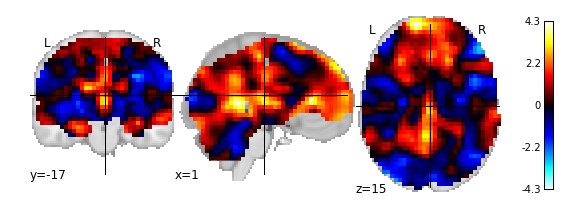

In [3]:
# Load the necessary packages
%matplotlib inline 
import nibabel as nb # Nibabel for loading in imaging data
from nilearn import plotting # Nilearn .plotting for all the nice plots

# Data directory, adjust accordingly
data_dir = '/media/all_data/BRAINHACK/SurfacePlotting/'

# The name of the statistical map
stat_map_file = data_dir  + '/spmT_0001_HEminLE.nii.gz'
stat_map = nb.load(stat_map_file)

# Plot an unthresholded map of your file
plot = plotting.plot_stat_map(stat_map)

### Preparing Statistical Map

In a first step you have to register your statistical map onto your subject. This is done by mri_vol2surf.

    mri_vol2surf --src $YOUR_DIR/YOUR_STATMAP.nii --hemi rh  --float2int round --o YOUR_STATMAP_OUT.mgz --projfrac 0.5 --trgsubject fsaverage --regheader fsaverage  

In this example the T-map in MNI space is mapped onto the right hemisphere of the fsaverage subject. 
* --src is the source file, your statistical map
* --hemi defines the hemisphere rh for right, lh for left
* --o defines the output file and output directory, output is by default into source directory
* --trgsubject defines the subject onto which the statistical map should be registered, uses your SUBJECTS_DIR directory by default
* --regheader uses the subject header for registration information
* --projfrac from the freesurfer documentation: "fraction (0,1) of the cortical thickness at each vertex to project along the surface normal. Default=0. When set at 0.5 with the white surface, this should sample in the middle of the cortical surface. This requires that a ?h.thickness file exist for the source subject. Note, the faction can be less than zero, in which case it will project into the white matter. See also --projdist."

* --float2int from freesurfer documentation: "Override float2int method in registration file. See BUGS." 

The new surface file needs to be transformed into ascii. The vtk file format is the format of choice here. As mri_vol2surf outputs a 1 dimensional curvature file, you also need to add a surface file which provides the coordinates for each value. 

    mris_convert -c $YOUR_DIR/YOUR_STATMAP_OUT.mgz $FREESURFER_HOME/subjects/fsaverage/surf/rh.orig  $YOUR_DIR/YOUR_STATMAP_OUT.vtk

The first and last entry are as above, the second entry defines the reference surface onto which the statistical map was projected. Freesurfer adds a 'rh.' or 'lh.' automatically to the beginning of the file, depending on what hemisphere you extracted if you use the --c flag.


## Loading the data using the vtk_tools

In [6]:
from vtk_rw import read_vtk

rh_stat = data_dir + 'rh.stat_map.vtk'

vertices_stat, faces_stat, data_stat = read_vtk(rh_stat)

mesh_stat = {'coords':vertices_stat, 'faces':faces_stat}


### Plot original surface:

/usr/lib/python3/dist-packages/matplotlib/collections.py:571: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors == str('face'):


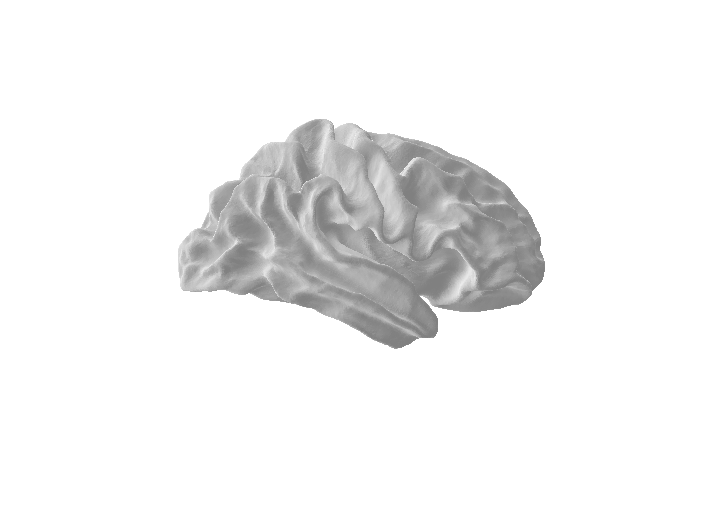

In [7]:
import seaborn as sns
from nilearn import plotting
sns.set_style('white')
sns.set_context('poster')

plot = plotting.plot_surf_stat_map(mesh_stat, 'rh', figsize = (15, 10))



/usr/lib/python3/dist-packages/matplotlib/collections.py:571: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors == str('face'):


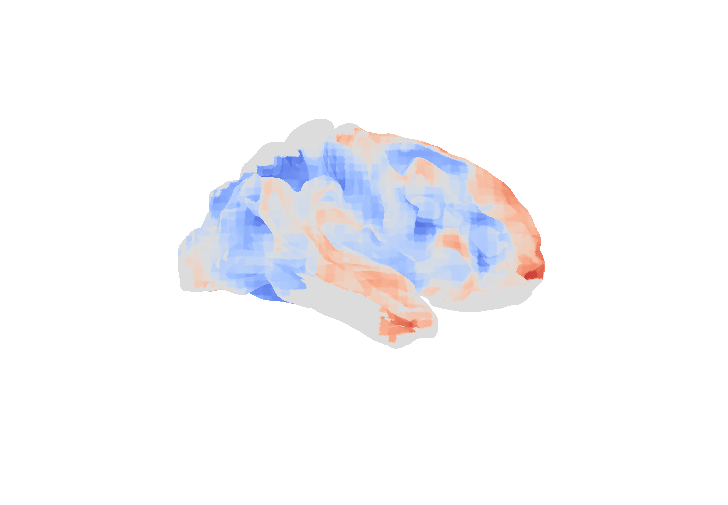

In [8]:
plot = plotting.plot_surf_stat_map(mesh_stat, 'rh' ,stat_map = data_stat, threshold = 0,  figsize = (15, 10))

## Getting Curvature data:

To extract the curvature file of the average subject you basically need to run a similiar command as for the extraction of the surface data of the statitical map.

    mris_convert -c $FREESURFER_HOME/subjects/fsaverage/surf/rh.curv $FREESURFER_HOME/subjects/fsaverage/surf/rh.orig  $YOUR_DIR/YOUR_CURVATURE_OUT.vtk
    


/usr/lib/python3/dist-packages/matplotlib/collections.py:571: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors == str('face'):


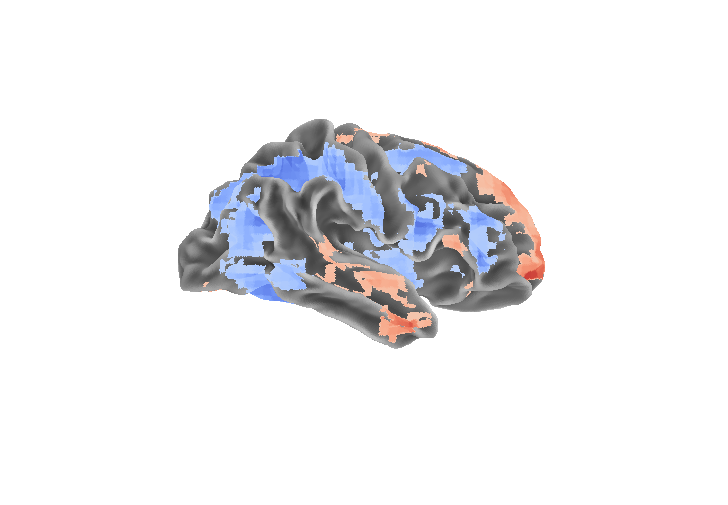

In [10]:
rh_curv = data_dir + 'rh.rh_curvature.vtk'

vertices_curv, faces_curv, data_curv = read_vtk(rh_curv) 
# We only need the data for the curvature

plot = plotting.plot_surf_stat_map(mesh_stat, 'rh' ,stat_map = data_stat, bg_map = data_curv, threshold = 1,  figsize = (15, 10))


## Plotting on the white matter surface

You can also extract the inflated brain mesh of the subject:

    mris_convert  $FREESURFER_HOME/subjects/fsaverage/surf/rh.white  $YOUR_DIR/YOUR_WHITE_OUT.vtk

In [12]:
rh_inflated = data_dir + 'rh_inflated.vtk'

vertices_inflated, faces_inflated, data_inflated = read_vtk(rh_inflated)

mesh_inflated = {'coords':vertices_inflated, 'faces':faces_inflated}


/usr/lib/python3/dist-packages/matplotlib/collections.py:571: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors == str('face'):


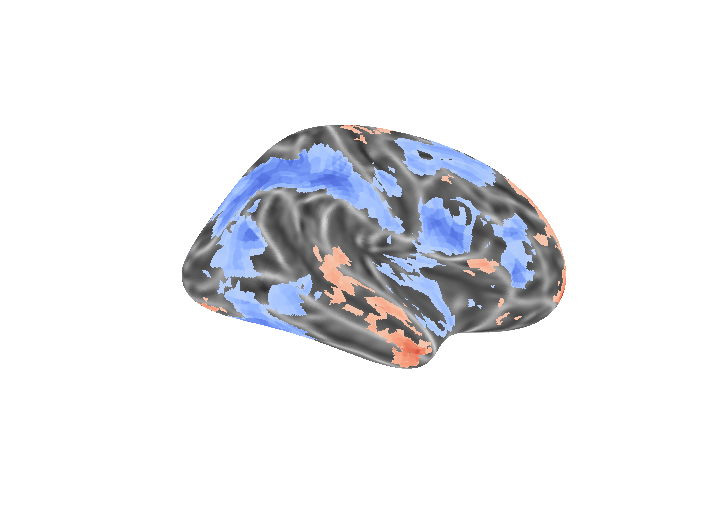

In [13]:
plot = plotting.plot_surf_stat_map(mesh_inflated, 'rh' ,stat_map = data_stat, bg_map = data_curv, threshold = 1,  figsize = (15, 10))


## Polygon reduction

A note of caution here: the extracted meshes are very detailed and take a long time to render, so you might want to decrease the number of polygons. This can be done with some free-software. Meshlabs and Blender3D being the most obivous choices. 